#Circle Packing Optimization Algorithm - Final Project

**Prepared by:** Prof. Alexander Dowling, Landi Wang (lwang25@nd.edu, 2024) & Yi Liu (yliu66@nd.edu, 2024)

## Learning Objective
* Review syntax for Pyomo package
* Demonstrate the power of Pyomo in solving and optimizing complex dynamic process systems
* Learn how to formulate non-linear optimization problem
* Verify Hexagonal Lattice Theory

## Primary Source
https://ndcbe.github.io/optimization/notebooks/1/NLP.html

Going from the circle packing example mentioned above, we wanted to examine the validity of the hexagonal lattice theory and thus changed and reformulated our model. Compared to the circle packing example demonstrated in the link above, which was optimizing finding the optimal radius for each individual circle and their centers' locations respectively, we aim to set all the radii of circles to be equal to each other, while the values of all radii and the coordinates of the circles are left to be determined by the model.

##Install/Import Packages

In [ ]:
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.easy_install()
else:
    sys.path.insert(0, '../')
    import helper
helper.set_plotting_style()

import pandas as pd
import pyomo.environ as pyo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from IPython.display import display, Math

### Suppress warning when initializing the problem to values outside the bounds
import logging
logging.getLogger('pyomo.core').setLevel(logging.ERROR)

--2024-12-19 00:52:23--  https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6493 (6.3K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   6.34K  --.-KB/s    in 0s      

2024-12-19 00:52:24 (68.8 MB/s) - ‘helper.py’ saved [6493/6493]

Installing idaes via pip...
idaes was successfully installed
idaes, version 2.7.0


Running idaes get-extensions to install Ipopt, k_aug, and more...
Checking solver versions:
Ipopt 3.13.2 (x86_64-pc-linux-gnu), ASL(20190605)



[K_AUG] 0.1.0, Part of the IDAES PSE framework
Please visit https://idaes.org/ (x86_64-pc-linux-gnu), ASL(20190605)



Couenne 0.5.8 -- an Open-Source solver for Mixed Integer Nonlinear Optimiz

##Packing Optimization: Model Description and Formulation
In our scenario, we want to fit the given number of circles within the given rectangle (Width 10 and Length 8 in our case). The objective is to maximize the packing density, which is defined by the following formula: $$
\eta_{\text{opt}} = \max\left(\frac{n \pi r^2}{A \times B}\right)
$$

The constraints are as follows:
### Non-overlap constraint:

$$
\sqrt{(x_i - x_j)^2 + (y_i - y_j)^2} \geq 2r, \quad \text{for all} \, i < j
$$

### Boundary constraint:

$$
r \leq x_i \leq A - r, \quad r \leq y_i \leq B - r
$$

###Attempt 1: No Radius Initialization
We intended this to be simple and to introduce the optimization problem, with no initialization at all on the radius. The objective is to maximize the packing density of the system, while there can be no overlaps between circles or circles being out of bounaries that we appointed. The number of circles is given by the user, while the algorithm deterimines the coordinates of the center of the circles as well as the radius of the circles.

In [ ]:
# Data
L = 8  # Length of the rectangle
W = 10   # Width of the rectangle
N = 20   # Preset number of circles

# Model
model = pyo.ConcreteModel()

# Sets
model.circles = pyo.RangeSet(1, N)

# Variables
model.radius = pyo.Var(within=pyo.NonNegativeReals)  # Radius of all circles
model.x = pyo.Var(model.circles, bounds=(0, L))  # x-coordinates of circle centers
model.y = pyo.Var(model.circles, bounds=(0, W))  # y-coordinates of circle centers

# Objective: Maximize the total area occupied by circles
model.obj = pyo.Objective(
    expr=N * math.pi * model.radius**2,
    sense=pyo.maximize
)

# Constraints
# Ensure circles do not overlap
model.no_overlap = pyo.ConstraintList()
for i in range(1, N+1):
    for j in range(i+1, N+1):
        model.no_overlap.add(
            (model.x[i] - model.x[j])**2 + (model.y[i] - model.y[j])**2 >=
            (2 * model.radius)**2
        )

# Ensure circles stay within the rectangle
model.boundary_constraints = pyo.ConstraintList()
for i in model.circles:
    model.boundary_constraints.add(model.x[i] + model.radius <= L)
    model.boundary_constraints.add(model.x[i] - model.radius >= 0)
    model.boundary_constraints.add(model.y[i] + model.radius <= W)
    model.boundary_constraints.add(model.y[i] - model.radius >= 0)

# Solve
solver = pyo.SolverFactory('ipopt')  # Nonlinear solver
solver.solve(model, tee=False)

# Results
optimal_radius = pyo.value(model.radius)
print(f"Optimal Radius: {optimal_radius:.2f}")
total_area_circles = N * math.pi * optimal_radius**2
rectangle_area = L * W
packing_density = total_area_circles / rectangle_area
print(f"Packing Density: {packing_density:.2f}")

print("\nCircle Placements:")
x_coords = [pyo.value(model.x[i]) for i in model.circles]
y_coords = [pyo.value(model.y[i]) for i in model.circles]
for i in model.circles:
    print(f"Circle {i}: Center=({x_coords[i-1]:.2f}, {y_coords[i-1]:.2f})")

Optimal Radius: 0.97
Packing Density: 0.73

Circle Placements:
Circle 1: Center=(5.98, 5.48)
Circle 2: Center=(2.64, 7.41)
Circle 3: Center=(3.69, 9.03)
Circle 4: Center=(5.36, 8.07)
Circle 5: Center=(7.03, 1.93)
Circle 6: Center=(0.97, 2.59)
Circle 7: Center=(7.03, 7.10)
Circle 8: Center=(2.64, 3.55)
Circle 9: Center=(4.31, 6.45)
Circle 10: Center=(5.36, 0.97)
Circle 11: Center=(5.36, 2.90)
Circle 12: Center=(0.97, 4.52)
Circle 13: Center=(1.09, 8.92)
Circle 14: Center=(7.03, 3.86)
Circle 15: Center=(7.03, 9.03)
Circle 16: Center=(2.64, 5.48)
Circle 17: Center=(2.02, 0.97)
Circle 18: Center=(0.97, 6.45)
Circle 19: Center=(4.31, 4.52)
Circle 20: Center=(3.69, 1.93)


###Visualization Function

In [ ]:
def visualize_equal_radius_packing(rect_length, rect_width, radius, x_coords, y_coords):
    """
    Visualize the rectangle, equal-radius packed circles, and their centers.

    Parameters:
        rect_length (float): Length of the rectangle.
        rect_width (float): Width of the rectangle.
        radius (float): Radius of the circles.
        x_coords (list): x-coordinates of the circle centers.
        y_coords (list): y-coordinates of the circle centers.
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Draw the rectangle
    rect = patches.Rectangle((0, 0), rect_length, rect_width, linewidth=1.5, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

    # Draw each circle and its center
    for i in range(len(x_coords)):
        # Draw circle
        circle = patches.Circle((x_coords[i], y_coords[i]), radius, edgecolor='blue', facecolor='lightblue', alpha=0.7)
        ax.add_patch(circle)

        # Plot circle center
        ax.plot(x_coords[i], y_coords[i], 'ro')  # Red dot for the center

        # Label the circle center with its index
        ax.text(x_coords[i], y_coords[i], f"{i+1}", color='black', fontsize=10, ha='center', va='center')

    # Set plot limits
    ax.set_xlim(-1, rect_length + 1)
    ax.set_ylim(-1, rect_width + 1)

    # Add labels and title
    ax.set_title("Equal Radius Circle Packing Visualization")
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_aspect('equal', adjustable='box')

    plt.grid(True)
    plt.show()

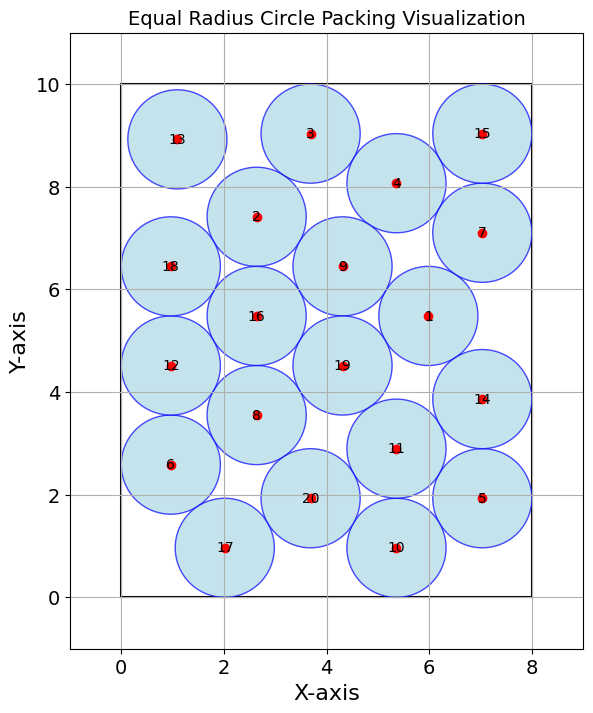

In [ ]:
visualize_equal_radius_packing(L, W, optimal_radius, x_coords, y_coords)

In this example, we have used the IPOPT solver. Although IPOPT is designed for convex problems and our circle packing problem is non-convex, discontinuous at certain points, and thus may have multiple local solutions or no solutions at all with different initialization points, we did decide to use it for its convenience as well as its capability of solving non-integer problems. This mismatch between the solver and the nature of our problem also caused the number of iterations to be extremely high, at 993.

###Packing Density vs. Number of Circles

No feasible solution for N = 3
No feasible solution for N = 4
No feasible solution for N = 5
No feasible solution for N = 6
No feasible solution for N = 7
No feasible solution for N = 8
No feasible solution for N = 9
No feasible solution for N = 18
No feasible solution for N = 19


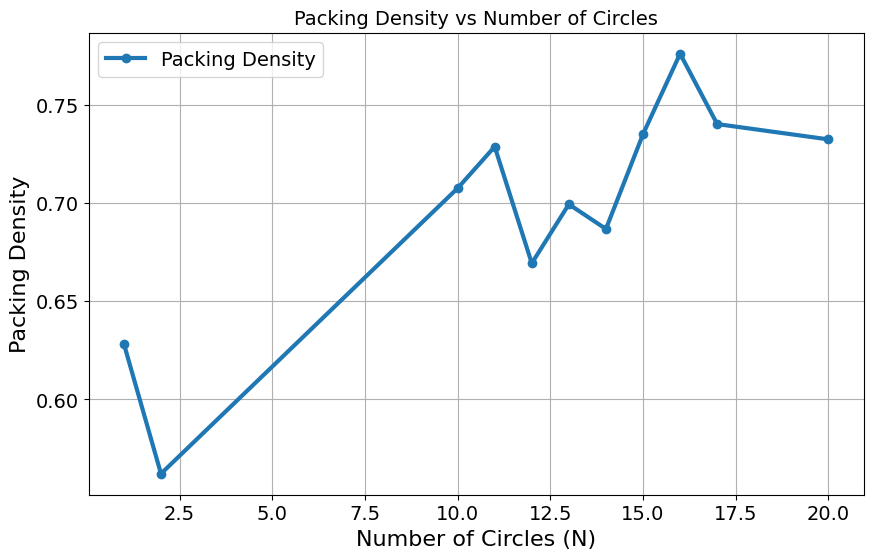

In [ ]:
N_max = 20  # Upper bound for the number of circles

# Function to solve the circle packing problem for a given N
def solve_circle_packing(N, L, W):
    model = pyo.ConcreteModel()

    # Sets
    model.circles = pyo.RangeSet(1, N)

    # Variables
    model.radius = pyo.Var(within=pyo.NonNegativeReals)  # Radius of all circles
    model.x = pyo.Var(model.circles, bounds=(0, L))  # x-coordinates of circle centers
    model.y = pyo.Var(model.circles, bounds=(0, W))  # y-coordinates of circle centers

    # Objective: Maximize the total area occupied by circles
    model.obj = pyo.Objective(
        expr=N * math.pi * model.radius**2,
        sense=pyo.maximize
    )

    # Constraints
    # Ensure circles do not overlap
    model.no_overlap = pyo.ConstraintList()
    for i in range(1, N+1):
        for j in range(i+1, N+1):
            model.no_overlap.add(
                (model.x[i] - model.x[j])**2 + (model.y[i] - model.y[j])**2 >=
                (2 * model.radius)**2
            )

    # Ensure circles stay within the rectangle
    model.boundary_constraints = pyo.ConstraintList()
    for i in model.circles:
        model.boundary_constraints.add(model.x[i] + model.radius <= L)
        model.boundary_constraints.add(model.x[i] - model.radius >= 0)
        model.boundary_constraints.add(model.y[i] + model.radius <= W)
        model.boundary_constraints.add(model.y[i] - model.radius >= 0)

    # Solve
    solver = pyo.SolverFactory('ipopt')  # Nonlinear solver
    results = solver.solve(model, tee=False)

    # Check if the solver found an optimal solution
    if results.solver.termination_condition == pyo.TerminationCondition.optimal:
        optimal_radius = pyo.value(model.radius)
        total_area_circles = N * math.pi * optimal_radius**2
        rectangle_area = L * W
        packing_density = total_area_circles / rectangle_area
        x_coords = [pyo.value(model.x[i]) for i in model.circles]
        y_coords = [pyo.value(model.y[i]) for i in model.circles]
        return packing_density, optimal_radius, x_coords, y_coords
    else:
        return None, None, None, None

# Iterate through N values and store results
results = []
for N in range(1, N_max + 1):
    packing_density, optimal_radius, x_coords, y_coords = solve_circle_packing(N, L, W)
    if packing_density is not None:
        results.append((N, packing_density, optimal_radius))
    else:
        print(f"No feasible solution for N = {N}")

# Plot results
if results:
    N_values, packing_densities, radii = zip(*results)
    plt.figure(figsize=(10, 6))
    plt.plot(N_values, packing_densities, marker='o', label='Packing Density')
    plt.title("Packing Density vs Number of Circles")
    plt.xlabel("Number of Circles (N)")
    plt.ylabel("Packing Density")
    plt.legend()
    plt.grid(True)
    plt.show()

As exhibited in the graph and the textual output, for circle numbers 3, 4, 5, 6, 7, 8, 9, 18, 19, no feasible solutions are found by our model (with no initialization). We have thus made the hypothesis that if an adequate initialization is given to our model as the radius, the model would gurantee a local optimal output.

###Attempt 2: Providing Arbitrary Initialization to the Radius
In this section, we have attempted to give an arbitray initialization radius to our model, and also attempting to initialize the circle center coordinates in a grid-like pattern. Both practices serve the purpose of providing the model an initialization point to start with.

In [ ]:
# Data
L = 8  # Length of the rectangle
W = 10  # Width of the rectangle
N = 25  # Preset number of circles
radius_init = 3

# Model
model = pyo.ConcreteModel()

# Sets
model.circles = pyo.RangeSet(1, N)

# Variables
model.radius = pyo.Var(within=pyo.NonNegativeReals, initialize=radius_init)  # Initial radius guess
model.x = pyo.Var(model.circles, bounds=(0, L))  # x-coordinates of circle centers
model.y = pyo.Var(model.circles, bounds=(0, W))  # y-coordinates of circle centers

# Initialize circle positions with a simple grid or rough arrangement
def init_positions(model):
    # Initial guess: arrange circles in a grid pattern (simple layout)
    rows = int(np.sqrt(N))
    cols = int(np.ceil(N / rows))
    for i in model.circles:
        row = (i - 1) // cols
        col = (i - 1) % cols
        model.x[i].value = (L / cols) * col + model.radius.value
        model.y[i].value = (W / rows) * row + model.radius.value

init_positions(model)

# Objective: Maximize the total area occupied by circles
model.obj = pyo.Objective(
    expr=N * math.pi * model.radius**2,
    sense=pyo.maximize
)

model.no_overlap = pyo.ConstraintList()
for i in range(1, N+1):
    for j in range(i+1, N+1):
        model.no_overlap.add(
            (model.x[i] - model.x[j])**2 + (model.y[i] - model.y[j])**2 >=
            (2*model.radius)**2
        )

model.boundary_constraints = pyo.ConstraintList()
for i in model.circles:
    model.boundary_constraints.add(model.x[i] + model.radius <= L)
    model.boundary_constraints.add(model.x[i] - model.radius >= 0)
    model.boundary_constraints.add(model.y[i] + model.radius <= W)
    model.boundary_constraints.add(model.y[i] - model.radius >= 0)

# Solver
solver = pyo.SolverFactory('ipopt')  # Nonlinear solver
solver.solve(model, tee=False)

# Results
optimal_radius = pyo.value(model.radius)
print(f"Optimal Radius: {optimal_radius:.2f}")
total_area_circles = N * math.pi * optimal_radius**2
rectangle_area = L * W
packing_density = total_area_circles / rectangle_area
print(f"Packing Density: {packing_density:.2f}")

# Circle Placements
print("\nCircle Placements:")
x_coords = [pyo.value(model.x[i]) for i in model.circles]
y_coords = [pyo.value(model.y[i]) for i in model.circles]
for i in model.circles:
    print(f"Circle {i}: Center=({x_coords[i-1]:.2f}, {y_coords[i-1]:.2f})")

Optimal Radius: 0.88
Packing Density: 0.76

Circle Placements:
Circle 1: Center=(0.88, 0.88)
Circle 2: Center=(4.08, 1.76)
Circle 3: Center=(5.60, 0.88)
Circle 4: Center=(7.12, 1.75)
Circle 5: Center=(7.12, 3.52)
Circle 6: Center=(2.33, 1.87)
Circle 7: Center=(4.11, 3.56)
Circle 8: Center=(5.60, 2.64)
Circle 9: Center=(5.63, 4.44)
Circle 10: Center=(7.12, 5.37)
Circle 11: Center=(0.88, 2.87)
Circle 12: Center=(2.37, 3.80)
Circle 13: Center=(4.14, 5.38)
Circle 14: Center=(5.63, 6.30)
Circle 15: Center=(7.12, 7.24)
Circle 16: Center=(0.88, 4.73)
Circle 17: Center=(2.40, 5.61)
Circle 18: Center=(2.40, 7.36)
Circle 19: Center=(4.15, 7.24)
Circle 20: Center=(5.64, 8.18)
Circle 21: Center=(0.88, 6.49)
Circle 22: Center=(0.88, 8.24)
Circle 23: Center=(2.40, 9.12)
Circle 24: Center=(4.16, 9.12)
Circle 25: Center=(7.12, 9.12)


In this attempt, our model did give us an output that makes sense, in other words local optimal points. However, we also found that with different initialization points, the output are slightly different, meaning that different initialization points would lead to different local optimal points. The specific packing density vs. initial radius is plotted as below:

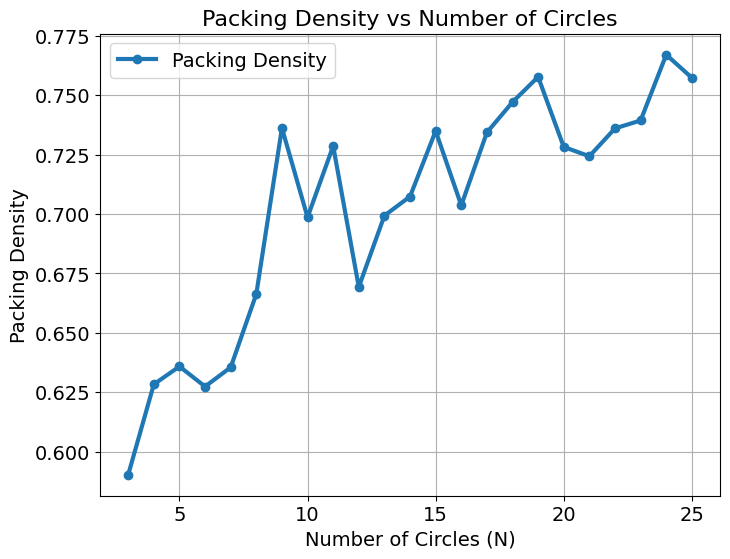

In [29]:

def packing_density_visualization(L, W, radius_init, min_circles=5, max_circles=50, step=1):
    packing_densities = []
    num_circles_range = range(min_circles, max_circles+1, step)
    unsolved_points = []  # List to store N values where the solution was not found

    for N in num_circles_range:
        # Model setup
        model = pyo.ConcreteModel()
        model.circles = pyo.RangeSet(1, N)
        model.radius = pyo.Var(within=pyo.NonNegativeReals, initialize=radius_init)
        model.x = pyo.Var(model.circles, bounds=(0, L))
        model.y = pyo.Var(model.circles, bounds=(0, W))

        # Initialize circle positions
        def init_positions(model):
            rows = int(np.sqrt(N))
            cols = int(np.ceil(N / rows))
            for i in model.circles:
                row = (i - 1) // cols
                col = (i - 1) % cols
                model.x[i].value = (L / cols) * col + model.radius.value
                model.y[i].value = (W / rows) * row + model.radius.value
        init_positions(model)

        # Objective function and constraints (same as in original code)
        model.obj = pyo.Objective(
            expr=N * math.pi * model.radius**2,
            sense=pyo.maximize
        )

        model.no_overlap = pyo.ConstraintList()
        for i in range(1, N+1):
            for j in range(i+1, N+1):
                model.no_overlap.add(
                    (model.x[i] - model.x[j])**2 + (model.y[i] - model.y[j])**2 >=
                    (2*model.radius)**2
                )

        model.boundary_constraints = pyo.ConstraintList()
        for i in model.circles:
            model.boundary_constraints.add(model.x[i] + model.radius <= L)
            model.boundary_constraints.add(model.x[i] - model.radius >= 0)
            model.boundary_constraints.add(model.y[i] + model.radius <= W)
            model.boundary_constraints.add(model.y[i] - model.radius >= 0)

        # Solve the model
        solver = pyo.SolverFactory('ipopt')
        results = solver.solve(model, tee=False)

        # Check if the solver has found a solution
        if results.solver.status != pyo.SolverStatus.ok:
            unsolved_points.append(N)  # Add N to the unsolved_points list if no solution was found
            packing_densities.append(None)  # Mark as None when there's no solution
        else:
            # Calculate packing density
            optimal_radius = pyo.value(model.radius)
            total_area_circles = N * math.pi * optimal_radius**2
            rectangle_area = L * W
            packing_density = total_area_circles / rectangle_area
            packing_densities.append(packing_density)

    # Print unsolved points where no solution was found
    if unsolved_points:
        print(f"Solutions were not found for the following numbers of circles: {unsolved_points}")

    # Plot packing density vs number of circles with styling similar to the provided graph
    plt.figure(figsize=(8, 6))
    plt.plot(num_circles_range, packing_densities, marker='o', label='Packing Density')
    plt.title('Packing Density vs Number of Circles', fontsize=16)
    plt.xlabel('Number of Circles (N)', fontsize=14)
    plt.ylabel('Packing Density', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

# Call the function to visualize packing density for different numbers of circles with smaller steps
packing_density_visualization(L=8, W=10, radius_init=3, min_circles=3, max_circles=25, step=1)


###Packing Density vs. Radius Initializations Graph

Trying initial radius: 0.1...
No feasible solution found.
Trying initial radius: 0.2...
No feasible solution found.
Trying initial radius: 0.30000000000000004...
No feasible solution found.
Trying initial radius: 0.4...
Packing Density: 0.7536, Optimal Radius: 0.8761
Trying initial radius: 0.5...
Packing Density: 0.7324, Optimal Radius: 0.8637
Trying initial radius: 0.6...
Packing Density: 0.7324, Optimal Radius: 0.8637
Trying initial radius: 0.7000000000000001...
Packing Density: 0.7317, Optimal Radius: 0.8633
Trying initial radius: 0.8...
Packing Density: 0.7285, Optimal Radius: 0.8614
Trying initial radius: 0.9...
Packing Density: 0.7285, Optimal Radius: 0.8614
Trying initial radius: 1.0...
Packing Density: 0.7285, Optimal Radius: 0.8614
Trying initial radius: 2...
Packing Density: 0.7588, Optimal Radius: 0.8791
Trying initial radius: 3...
Packing Density: 0.7467, Optimal Radius: 0.8721
Trying initial radius: 4...
Packing Density: 0.7262, Optimal Radius: 0.8601
Trying initial radius

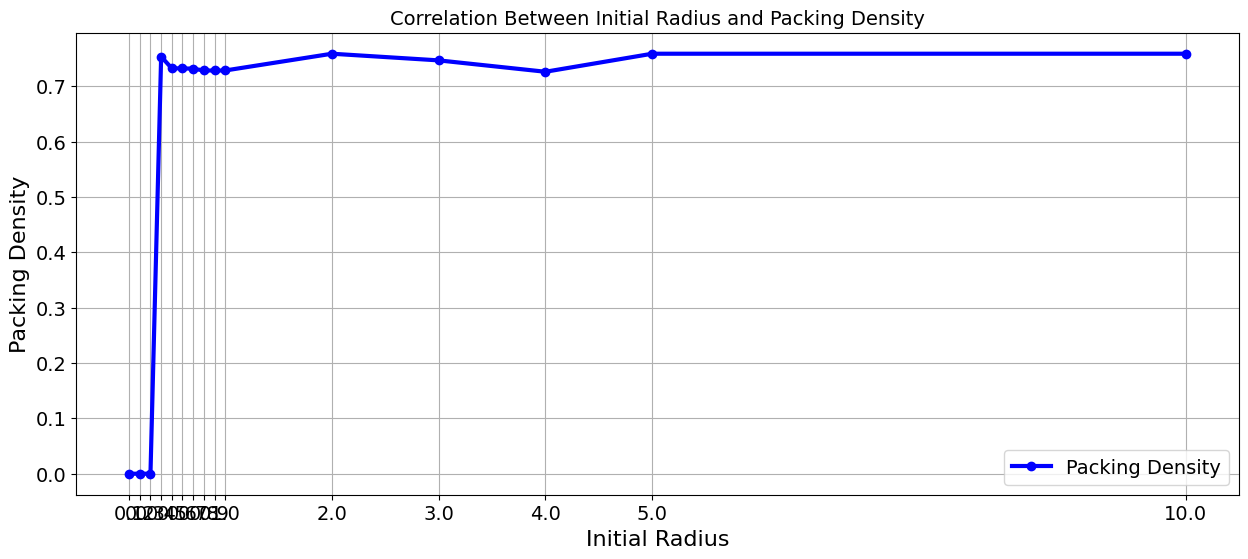

In [ ]:
# Data
L = 10  # Length of the rectangle
W = 8   # Width of the rectangle
N = 25   # Number of circles
initial_radii = list(np.arange(0.1, 1.1, 0.1)) + [2, 3, 4, 5, 10]
def solve_circle_packing_with_initial_radius(N, L, W, r_init):
    """
    Solve the circle packing problem with a given initial radius.

    Parameters:
        N (int): Number of circles
        L (float): Length of the rectangle
        W (float): Width of the rectangle
        r_init (float): Initial radius guess

    Returns:
        packing_density (float): Packing density from the optimal solution
        optimal_radius (float): Optimized radius
    """
    model = pyo.ConcreteModel()

    # Sets
    model.circles = pyo.RangeSet(1, N)

    # Variables
    model.radius = pyo.Var(within=pyo.NonNegativeReals)  # Radius of all circles
    model.x = pyo.Var(model.circles, bounds=(0, L))  # x-coordinates of circle centers
    model.y = pyo.Var(model.circles, bounds=(0, W))  # y-coordinates of circle centers

    # Objective: Maximize the total area occupied by circles
    model.obj = pyo.Objective(
        expr=N * math.pi * model.radius**2,
        sense=pyo.maximize
    )

    # Constraints
    # Ensure circles do not overlap
    model.no_overlap = pyo.ConstraintList()
    for i in range(1, N+1):
        for j in range(i+1, N+1):
            model.no_overlap.add(
                (model.x[i] - model.x[j])**2 + (model.y[i] - model.y[j])**2 >=
                (2 * model.radius)**2
            )

    # Ensure circles stay within the rectangle
    model.boundary_constraints = pyo.ConstraintList()
    for i in model.circles:
        model.boundary_constraints.add(model.x[i] + model.radius <= L)
        model.boundary_constraints.add(model.x[i] - model.radius >= 0)
        model.boundary_constraints.add(model.y[i] + model.radius <= W)
        model.boundary_constraints.add(model.y[i] - model.radius >= 0)

    # Set initial radius
    model.radius.set_value(r_init)

    # Solve
    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model, tee=False)

    # Check if the solver found an optimal solution
    if results.solver.termination_condition == pyo.TerminationCondition.optimal:
        optimal_radius = pyo.value(model.radius)
        total_area_circles = N * math.pi * optimal_radius**2
        rectangle_area = L * W
        packing_density = total_area_circles / rectangle_area
        return packing_density, optimal_radius
    else:
        return None, None

# Iterate through different initial radii and store results
packing_densities = []
optimal_radii = []

for r_init in initial_radii:
    print(f"Trying initial radius: {r_init}...")
    packing_density, optimal_radius = solve_circle_packing_with_initial_radius(N, L, W, r_init)
    if packing_density is not None:
        packing_densities.append(packing_density)
        optimal_radii.append(optimal_radius)
        print(f"Packing Density: {packing_density:.4f}, Optimal Radius: {optimal_radius:.4f}")
    else:
        packing_densities.append(0)
        optimal_radii.append(0)
        print("No feasible solution found.")

# Adding labels and title
plt.figure(figsize=(15, 6))
plt.plot(initial_radii, packing_densities, marker='o', linestyle='-', color='b', label='Packing Density')
plt.xticks(initial_radii)

# Adding labels and title
plt.title("Correlation Between Initial Radius and Packing Density")
plt.xlabel("Initial Radius")
plt.ylabel("Packing Density")
plt.grid(True)
plt.legend()

# Display the plot
plt.show()

As shown in the graph, on the left hand side, the packing density fluctuates extensively with different initialization values given to the radius. We believe this is because the non-convex nature of our problem and the existence of multiple local optimal points that has led our model to behave this way.

###Attempt 3: Iterative Algorithm
After learning from the 2nd attempt, we had the idea of building a iterative refinement algorithm for solving for the local optimal solution. The skeleton of our algorithm is still starting off with a arbitrary starting point, preferably large, solving the model with the given point and retrieve a temporary solution of the radius; using the latest temporary radius solution as our new initialization value for the radius, and so on so forth. The stopping criteria is when the increase in our packing density compared to the last iteration is less than a certain threshold, in our case is set to 1E-4.

Iteration 1: Optimal Radius = 0.86
Packing Density = 0.725273
Iteration 2: Optimal Radius = 0.88
Packing Density = 0.755294
Iteration 3: Optimal Radius = 0.90
Packing Density = 0.793792
Iteration 4: Optimal Radius = 0.90
Packing Density = 0.793792
Converged at iteration 4.

Final Optimal Radius: 0.90
Final Packing Density: 0.793792


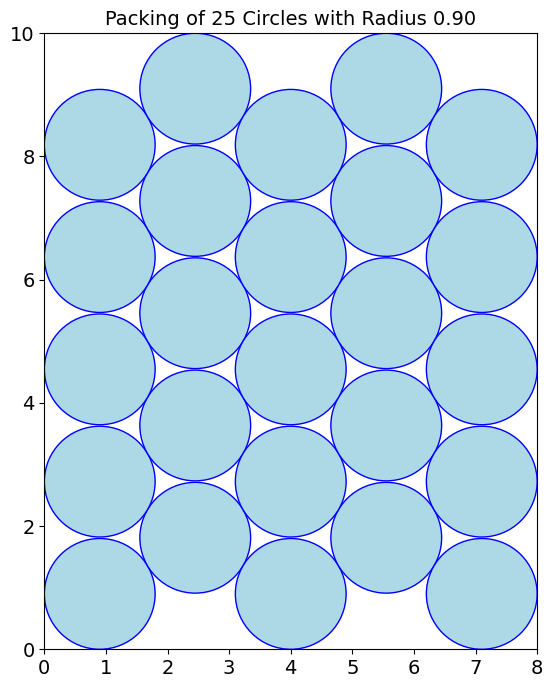

In [ ]:
# Data
L = 8  # Length of the rectangle
W = 10  # Width of the rectangle
N = 25  # Preset number of circles
threshold = 1e-4  # Stopping threshold for packing density change

# Model creation function
def create_model(radius_init):
    model = pyo.ConcreteModel()

    # Sets
    model.circles = pyo.RangeSet(1, N)

    # Variables
    model.radius = pyo.Var(within=pyo.NonNegativeReals, initialize=radius_init)  # Initialize radius
    model.x = pyo.Var(model.circles, bounds=(0, L))  # x-coordinates of circle centers
    model.y = pyo.Var(model.circles, bounds=(0, W))  # y-coordinates of circle centers

    # Initialize circle positions with a simple grid or rough arrangement
    def init_positions(model):
        # Initial guess: arrange circles in a grid pattern (simple layout)
        rows = int(np.sqrt(N))
        cols = int(np.ceil(N / rows))
        for i in model.circles:
            row = (i - 1) // cols
            col = (i - 1) % cols
            model.x[i].value = (L / cols) * col + model.radius.value
            model.y[i].value = (W / rows) * row + model.radius.value

    init_positions(model)

    # Objective: Maximize the total area occupied by circles
    model.obj = pyo.Objective(
        expr=N * math.pi * model.radius**2,
        sense=pyo.maximize
    )

    # Relaxed Overlap Constraint: Allow circles to be closer initially (2 * radius)
    model.no_overlap = pyo.ConstraintList()
    for i in range(1, N+1):
        for j in range(i+1, N+1):
            model.no_overlap.add(
                (model.x[i] - model.x[j])**2 + (model.y[i] - model.y[j])**2 >=
                (2 * model.radius)**2  # Relaxed distance between circles
            )

    # Strict Boundary Constraints: Circle must remain within the boundary
    model.boundary_constraints = pyo.ConstraintList()
    for i in model.circles:
        model.boundary_constraints.add(model.x[i] + model.radius <= L)  # Circle should stay within the right boundary
        model.boundary_constraints.add(model.x[i] - model.radius >= 0)  # Circle should stay within the left boundary
        model.boundary_constraints.add(model.y[i] + model.radius <= W)  # Circle should stay within the top boundary
        model.boundary_constraints.add(model.y[i] - model.radius >= 0)  # Circle should stay within the bottom boundary

    return model

# Iterative Optimization Algorithm
def iterative_optimization(initial_radius, max_iterations=100):
    prev_packing_density = 0
    current_packing_density = 0
    iteration = 0
    radius = initial_radius
    x_coords = []
    y_coords = []

    while iteration < max_iterations:
        # Create and solve the model with the current radius
        model = create_model(radius)
        solver = pyo.SolverFactory('ipopt')  # Nonlinear solver
        solver.solve(model, tee=False)

        # Retrieve the optimal radius and packing density
        optimal_radius = pyo.value(model.radius)
        total_area_circles = N * math.pi * optimal_radius**2
        rectangle_area = L * W
        current_packing_density = total_area_circles / rectangle_area

        # Store the circle positions for visualization
        x_coords = [pyo.value(model.x[i]) for i in model.circles]
        y_coords = [pyo.value(model.y[i]) for i in model.circles]

        # Print iteration results
        print(f"Iteration {iteration + 1}: Optimal Radius = {optimal_radius:.2f}")
        print(f"Packing Density = {current_packing_density:.6f}")

        # Check for convergence (packing density change is below the threshold)
        if abs(current_packing_density - prev_packing_density) < threshold:
            print(f"Converged at iteration {iteration + 1}.")
            break

        # Update for next iteration
        prev_packing_density = current_packing_density
        radius = optimal_radius  # Use the optimal radius for the next iteration
        iteration += 1

    return optimal_radius, current_packing_density, x_coords, y_coords

# Visualization Function
def visualize_packing(x_coords, y_coords, radius):
    fig, ax = plt.subplots(figsize=(8, 8))
    for i in range(N):
        circle = plt.Circle((x_coords[i], y_coords[i]), radius, edgecolor='blue', facecolor='lightblue', lw=1)
        ax.add_artist(circle)

    ax.set_xlim(0, L)
    ax.set_ylim(0, W)
    ax.set_aspect('equal', 'box')
    ax.set_title(f"Packing of {N} Circles with Radius {radius:.2f}")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# Initial guess for radius
initial_radius = 5

# Run the iterative optimization
optimal_radius, packing_density, x_coords, y_coords = iterative_optimization(initial_radius)

# Final result
print(f"\nFinal Optimal Radius: {optimal_radius:.2f}")
print(f"Final Packing Density: {packing_density:.6f}")

# Visualize the final packing
visualize_packing(x_coords, y_coords, optimal_radius)

Iteration 1: Optimal Radius = 0.90
Packing Density = 0.793792
Iteration 2: Optimal Radius = 0.90
Packing Density = 0.793792
Converged at iteration 2.
Iteration 1: Optimal Radius = 0.87
Packing Density = 0.740478
Iteration 2: Optimal Radius = 0.88
Packing Density = 0.755294
Iteration 3: Optimal Radius = 0.90
Packing Density = 0.793792
Iteration 4: Optimal Radius = 0.90
Packing Density = 0.793792
Converged at iteration 4.
Iteration 1: Optimal Radius = 0.86
Packing Density = 0.732372
Iteration 2: Optimal Radius = 0.88
Packing Density = 0.755294
Iteration 3: Optimal Radius = 0.90
Packing Density = 0.793792
Iteration 4: Optimal Radius = 0.90
Packing Density = 0.793792
Converged at iteration 4.
Iteration 1: Optimal Radius = 0.86
Packing Density = 0.728479
Iteration 2: Optimal Radius = 0.88
Packing Density = 0.755294
Iteration 3: Optimal Radius = 0.90
Packing Density = 0.793792
Iteration 4: Optimal Radius = 0.90
Packing Density = 0.793792
Converged at iteration 4.
Iteration 1: Optimal Radius 

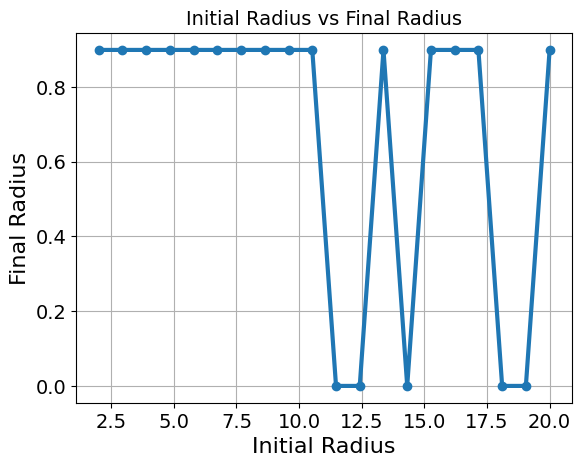

In [ ]:
initial_radii = np.linspace(2, 20, 20)  # Increased number of points for better visualization
final_radii = []

for i in initial_radii:
    a, b, c, d = iterative_optimization(i)
    final_radii.append(a)

plt.plot(initial_radii, final_radii, marker='o')
plt.xlabel('Initial Radius')
plt.ylabel('Final Radius')
plt.title('Initial Radius vs Final Radius')
plt.grid(True)
plt.show()

As shown in the graph above, for the majority of the starting points (15 out of 20), the radius converged to the same solution (to 1E-4), which is a significant improvement from the standard solution. However, we still cannot completely evade the issue of the model not converging in certain scenarios as the nature of our problem is non-convex.

##Conclusion
In this project, we aimed to solve the circle packing problem by deriving the radius and coordinates of circles within a given rectangular boundary to maximize the packing density. Initially, we attempted to model the problem using Pyomo, but encountered challenges due to the discontinuous and nonconvex nature of the problem, which often prevented the model from finding an optimal solution. After considering the problem's complexity, we introduced an arbitrary initial starting point, leading to the discovery of different optimal solutions for the same number of circles depending on the starting conditions. To address this issue, we developed an iterative algorithm that refines the solution in each iteration, using the previous iteration's optimal solution as the starting point. This approach allowed us to significantly improve convergence, with most cases converging to a single optimal solution, while a few starting points still did not yield solutions due to the discontinuity of our problem. Overall, our iterative approach provided a more reliable method for solving the circle packing problem, demonstrating the importance of considering the problem's nature and refining the solution process.